In [8]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [9]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [10]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [11]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [18]:
def enhanced_kdj_shadow_factor(df, n=9, m=3, rsi_window=14):
    """
    增强型KDJ-上影线组合因子
    结合KDJ压力因子和RSI背离增强的上影线因子，通过动态加权机制强化超买区域的信号
    
    参数:
    df: 包含OHLCV数据的DataFrame
    n: KDJ指标的周期 (默认9)
    m: KDJ指标的平滑周期 (默认3)
    rsi_window: RSI指标的周期 (默认14)
    """
    # 计算KDJ压力因子
    low_min = df['low'].rolling(n).min()
    high_max = df['high'].rolling(n).max()
    rsv = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-8)
    K = rsv.ewm(alpha=1/m, adjust=False).mean()
    D = K.ewm(alpha=1/m, adjust=False).mean()
    J = 3*K - 2*D
    kdj_pressure = (K + D + J)/3 - 50
    
    # 计算RSI背离增强的上影线因子
    rsi = ta.rsi(df['close'], length=rsi_window)
    overbought = np.where(rsi > 70, 1.5, 1.0)  # 超买区域放大信号
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    shadow_factor = (upper_shadow / df['open']) * overbought
    
    # 动态加权组合因子
    # 当KDJ显示超买压力时(正值)增强上影线因子
    # 当KDJ显示超卖支撑时(负值)减弱上影线因子
    pressure_weight = np.clip(kdj_pressure / 50, -1, 1)  # 归一化到[-1,1]
    combined_factor = shadow_factor * (1 + pressure_weight)
    
    # 加入成交量确认
    volume_weight = np.log(df['volume'] / df['volume'].rolling(20).mean() + 1)
    final_factor = combined_factor * volume_weight
    
    return final_factor

# 因子测试

In [19]:
evaluator.set_factor(
    factor_data_or_func=enhanced_kdj_shadow_factor,
    factor_name='enhanced_kdj_shadow_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.006880
   Rank_IC (Spearman): 0.001928
📊 信息比率:
   IR: 0.467457
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130692
   因子列: enhanced_kdj_shadow_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


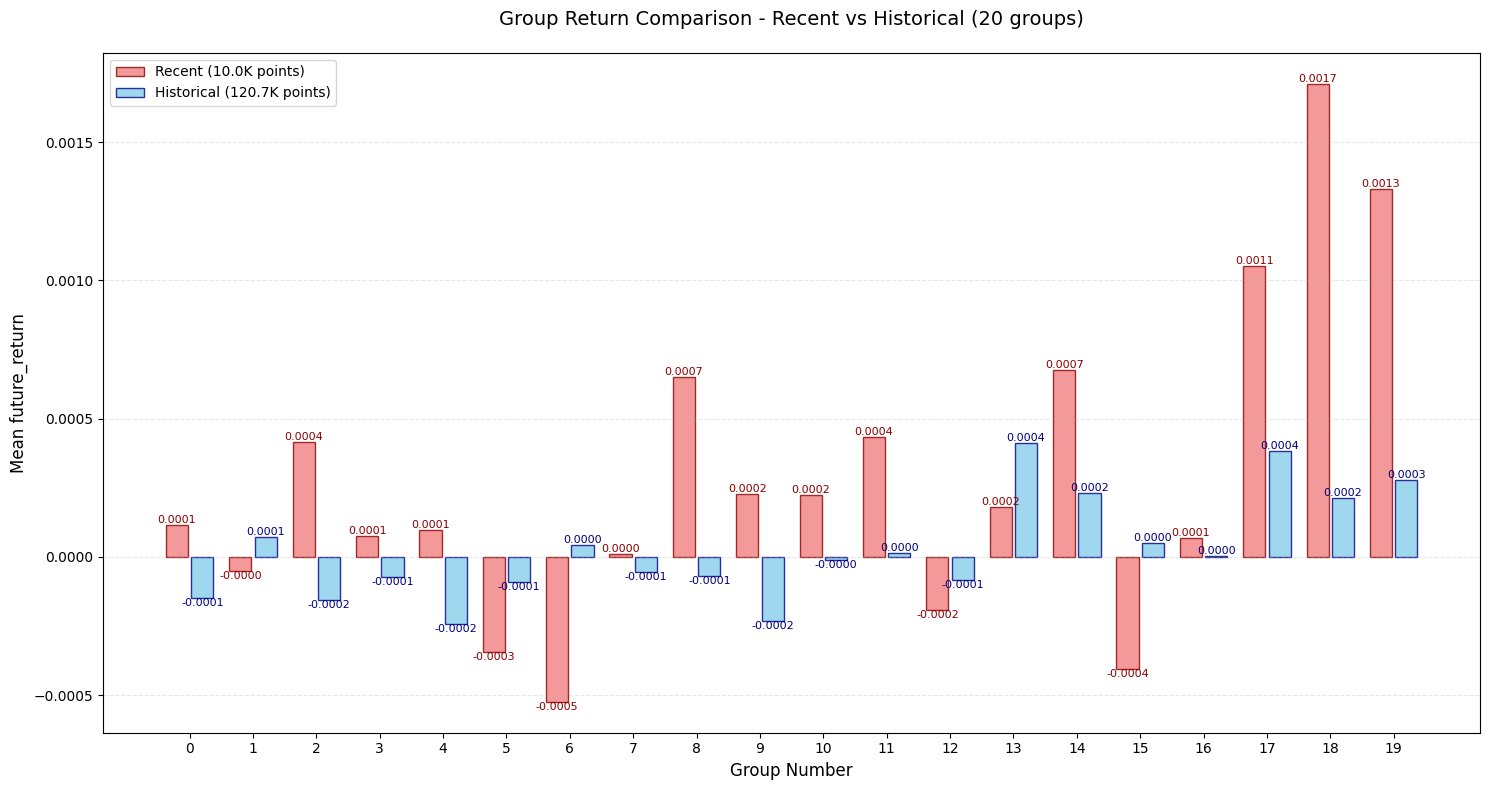

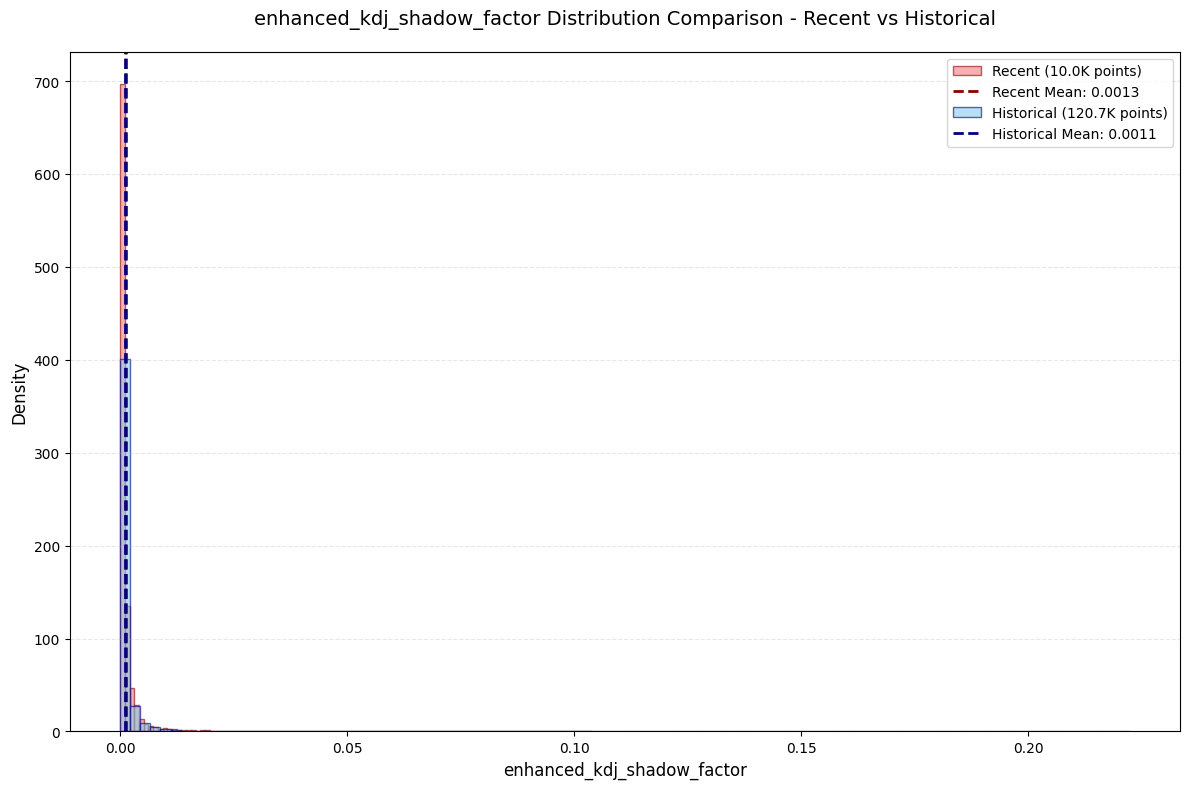

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [20]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)